# Replication with ICPE "Sampling Effect ..."

#### First, we import some libraries

In [21]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [22]:
ref_dir = './ICPE_sampling/'
inputs_count = 13
perf = ["size", "time"]

data = dict()
for i in range(inputs_count):
    df = pd.read_csv(ref_dir+str(i)+'.csv', dtype= float)
    df2 = pd.get_dummies(df.drop(["configurationID", "size", 
                                  "usertime", "systemtime", "elapsedtime"], axis = 1),
                         columns= ["ref", "rc_lookahead"], 
                         dtype = float)
    df2["size"] = df["size"]
    df2["time"] = df["elapsedtime"]
    data[i] = df2

inputs_feat = df2.columns[:len(df2.columns)-2]

In [23]:
data[0]

,H264,no_8x8dct,no_asm,no_cabac,no_deblock,no_fast_pskip,no_mbtree,no_mixed_refs,no_weightb,ref_1.0,ref_5.0,ref_9.0,rc_lookahead_20.0,rc_lookahead_40.0,rc_lookahead_60.0,size,time
0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,48.0,0.755
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,56.0,0.856
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,64.0,0.341
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,64.0,0.760
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,56.0,0.484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,68.0,0.359
1148,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,64.0,0.344
1149,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,64.0,0.348
1150,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,64.0,0.547


# RQ1 results

In [24]:
def plot_correlationmatrix_dendogram(dim):
    # dim : dimension
    # output : a plot of an ordered correlogram
    
    # number of inputs
    inputs_nb = inputs_count

    corr = [[0 for x in range(inputs_nb)] for y in range(inputs_nb)]

    for i in range(inputs_nb):
        for j in range(inputs_nb):
            # A distribution of bitrates will have a correlaiton of 1 with itself
            if (i == j):
                corr[i][j] = 1
            else:
                # we compute the Spearman correlation between the input video i and the input video j
                corr[i][j] = sc.spearmanr(data[i][dim],
                                          data[j][dim]).correlation

    # we transform our matrix into a dataframe
    df = pd.DataFrame(corr)
    # we replace nan correlations (with a distribution whose values are all equal to 0)
    df = df.fillna(0)

    # group the videos, we choose the ward method 
    # single link method (minimum of distance) leads to numerous tiny clusters
    # centroid or average tend to split homogeneous clusters
    # and complete link aggregates unbalanced groups. 
    links = linkage(df, method="ward",)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    # we order the correlation following the aggregation clustering
    mask = np.zeros_like(corr, dtype=np.bool)

    for i in range(inputs_nb):
        for j in range(inputs_nb):    
            if i>j:
                mask[order[i]][order[j]] = True
    
    # compute the actual clustermap
    g = sns.clustermap(df, cmap="vlag", mask=mask, method="ward",
                   linewidths=0, figsize=(13, 13), 
                   cbar_kws={"ticks":[k/5 for k in np.arange(-10,10,1)]}, 
                   vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    # abcissa and ordered labels
    g.ax_heatmap.set_xlabel("Inputs", fontsize = 18)
    g.ax_heatmap.set_ylabel("Inputs", fontsize = 18)
    # we save the figure in the result folder
    #plt.savefig("../../../results/systems/"+ns+"/"+"corr_"+dim+".png")
    # we show the graph
    plt.show()
    
    return corr

def describe(corr):
    
    corrDescription = [corr[i][j] for i in range(len(corr)) 
                              for j in range(len(corr)) if i >j]
    
    return np.round(pd.Series(corrDescription).describe(), 2)

## x264 - time

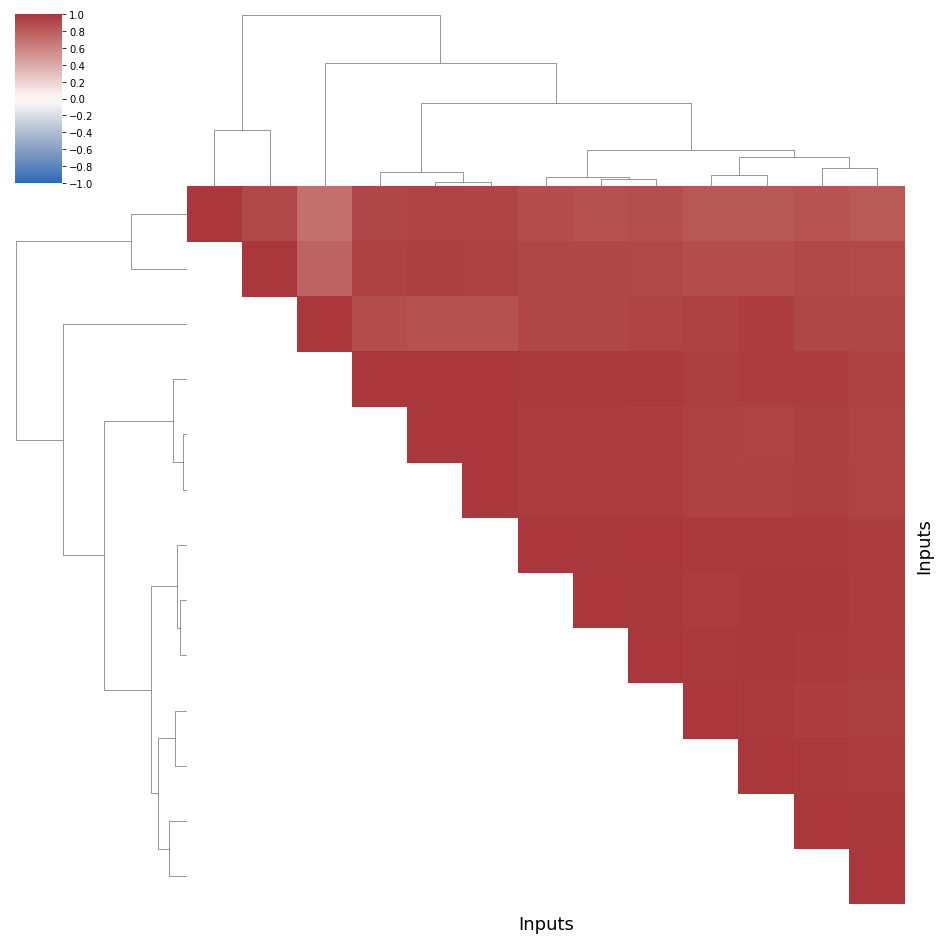

In [25]:
corr_time = plot_correlationmatrix_dendogram("time")

In [26]:
describe(corr_time)

count    78.00
mean      0.94
std       0.05
min       0.72
25%       0.92
50%       0.96
75%       0.98
max       1.00
dtype: float64

## x264 - size

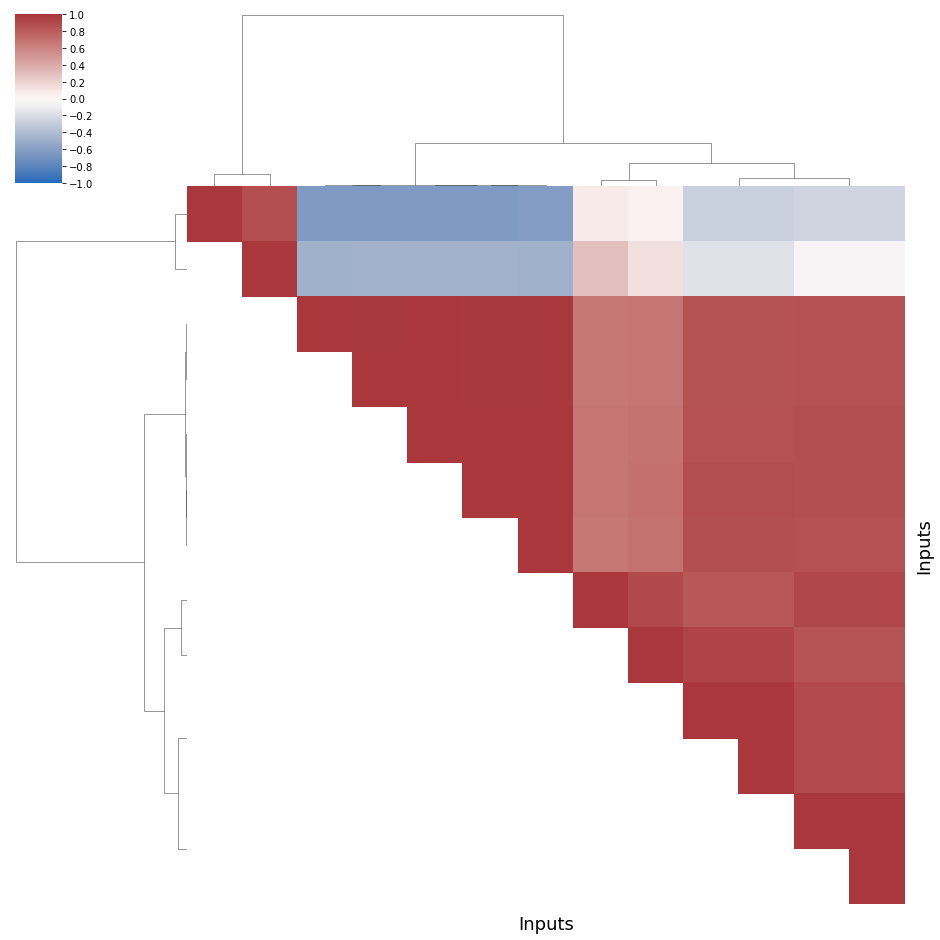

In [27]:
corr_size = plot_correlationmatrix_dendogram("size")

In [28]:
describe(corr_size)

count    78.00
mean      0.54
std       0.55
min      -0.64
25%       0.10
50%       0.87
75%       0.90
max       1.00
dtype: float64

# RQ2 results

In [29]:
def compute_importances(dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of importances
    listImportances = []
    
    features = inputs_feat
    to_keep = [f for f in features]
    to_keep.append(dim)

    # for each video of the list
    for id_input in range(inputs_count):
        
        # we replace missing numbers by 0
        df = data[id_input][to_keep]
        
        df = df.replace(to_replace = "None", value = '0')
        
        # standardization
        for col in features:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            arr_col = np.array(df[col], float)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            df[col] = arr_col
        
        # for each video, we train a model
        clf = RandomForestRegressor(n_estimators=20)
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = df[dim]
        # we train the model on all the data (not train-test since we don't use the model)
        clf.fit(X, y)
        
        # we add feature importances to the list
        listImportances.append(clf.feature_importances_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listImportances)):
        res['video_'+str(id_input)] = np.round(cs*listImportances[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

In [30]:
def compute_coefs(dim):
    # input : a list of videos
    # output : a dataframe of feature importances
    
    # the final list of coefficients
    listCoefs = []
    
    features = inputs_feat
    to_keep = [f for f in features]
    to_keep.append(dim)

    # for each video of the list
    for id_input in range(inputs_count):
        
        # we replace missing numbers by 0
        df = data[id_input][to_keep]
        
        df = df.replace(to_replace = "NaN", value = '0')
        df = df.replace(to_replace = "None", value = '0')

        # standardization
        for col in to_keep:
            # we center and reduce the quantitative variables
            # i.e substract the mean, and divide by the standard deviation
            # to avoid the scale of the vars to interfere with the learning process
            arr_col = np.array(df[col], float)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            df[col] = arr_col

        # for each video, we train a model
        indexes = np.array([k for k in range(len(df[dim])) 
                            if df[dim][k] != float("inf") and not np.isnan(df[dim][k])],int)
        lr = LinearRegression()
        # we use all the configuration options as predicting variables
        X = df.drop([dim], axis=1)
        # and the bitrate distribution of the video as a variable to predict
        y = [float(k) for k in df[dim]]
        #print(y)
        # we train the model on all the data (not train-test since we don't use the model)
        lr.fit(X, y)
        # we add feature importances to the list
        listCoefs.append(lr.coef_)
    
    # final dataframe of feature importances
    res = pd.DataFrame({'features' : features})
    
    # significative numbers p, cs = 10^p
    cs = 100
    
    # we add the feature imps to the dataframe 
    for id_input in range(len(listCoefs)):
        res['video_'+str(id_input)] = np.round(cs*listCoefs[id_input])/cs
    
    # transpose it
    res = res.set_index('features').transpose()
    
    # return it 
    return res

In [31]:
def boxplot_imp(dim, xlim = None, xname='Importances'):
    ### in: 
    #### ns the name of the system
    #### dim the name of the current performance property
    #### xlim limits if needed to focus on the important part of the chart
    #### xname the name of the abcissae and if we compute the importances or the effects
    ### out :
    #### a boxplot (saved in the system file)
    
    if xname == 'Importances':
        res = compute_importances(dim)
    else:
        res = compute_coefs(dim)
    
    # sort by names
    listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
               for col in res.columns]
    listImp.sort(key=lambda tup: tup[2], reverse=True)

    # see figures 2a and 2b
    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    plt.show()

## x264 - time

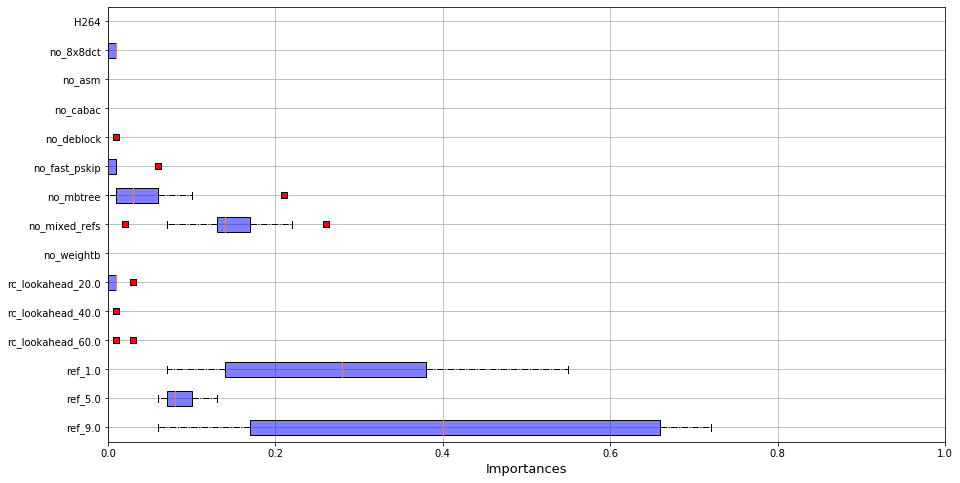

In [32]:
boxplot_imp("time", xlim =[0,1], xname='Importances')

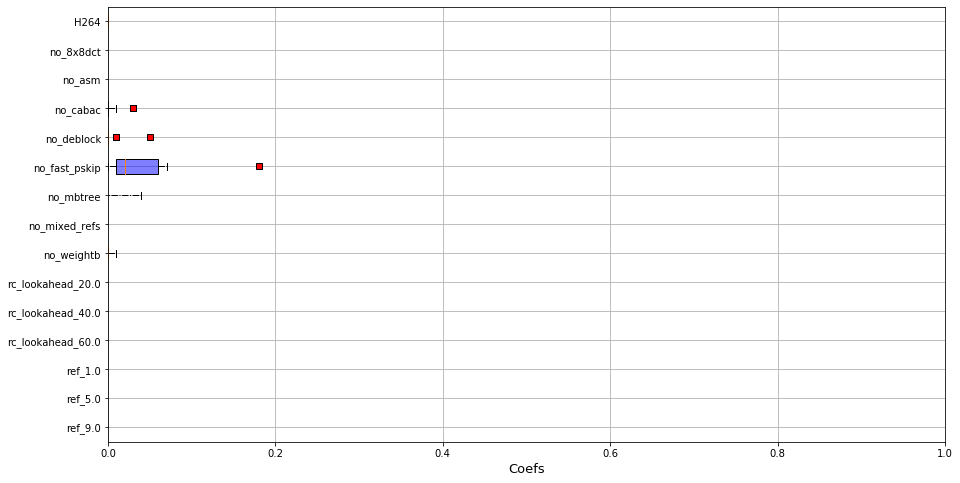

In [33]:
boxplot_imp("time", xlim =[0,1], xname='Coefs')

## x264 - size

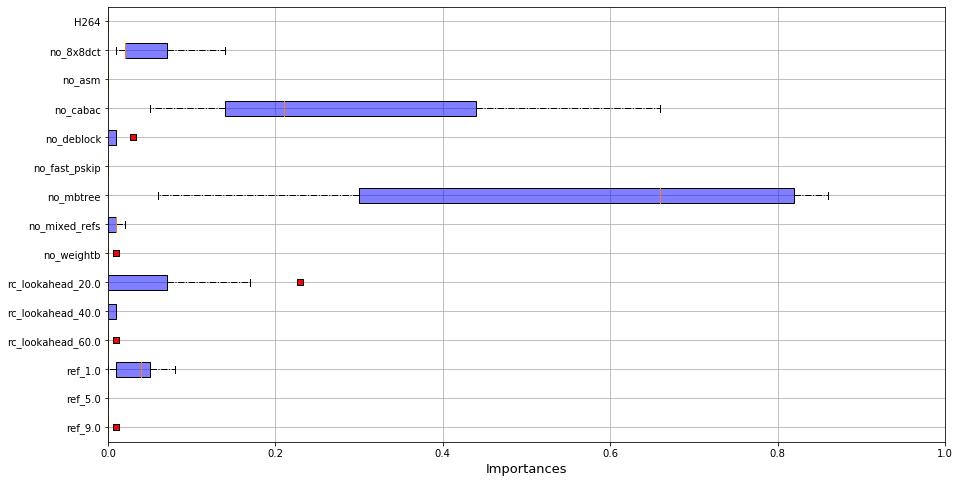

In [34]:
boxplot_imp("size", xlim =[0,1], xname='Importances')

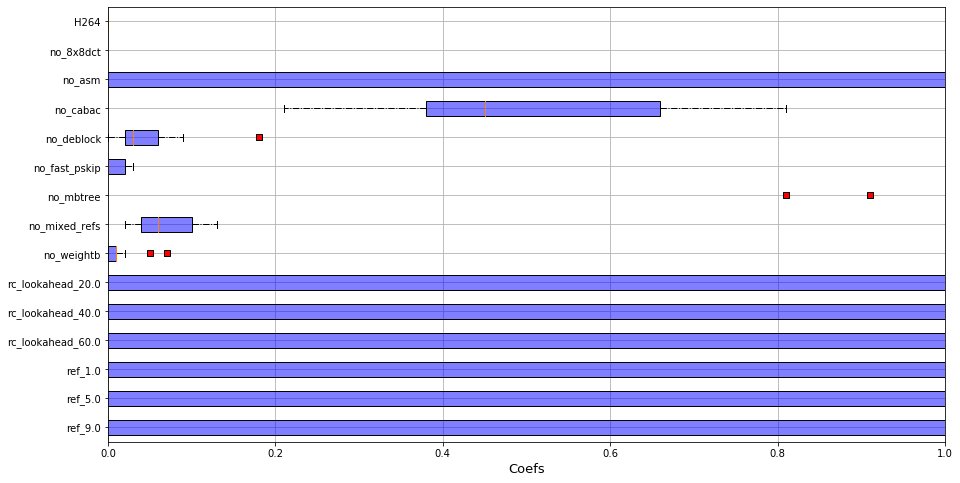

In [35]:
boxplot_imp("size", xlim =[0,1], xname='Coefs')

# RQ3 results

In [36]:
def get_ratios(perf):
    
    ratios = []
    
    nb_inputs = inputs_count
    
    for index_target in range(nb_inputs):

        list_ratios = []
        s1 = np.max(data[index_target][perf])

        for i in range(20):
            index_source = np.random.randint(nb_inputs)
            s2 = data[index_target][perf][np.argmax(data[index_source][perf])]
            # we drop the ratios that are division per 0 or nan values
            if not np.isnan(s1) and not np.isnan(s2) and s2!=0:
                # we drop the ratios too high because it is just due to the fact that s2 is too low 
                # and it increases the standard deviation
                if int(s1/s2) <= 50:
                    list_ratios.append(s1/s2)

        ratios.append(np.nanmean(list_ratios))

    return (np.nanmean(ratios), 
            np.nanstd(ratios), 
            np.nanpercentile(ratios,5),
            np.nanpercentile(ratios,25),
            np.nanmedian(ratios),
            np.nanpercentile(ratios,75),
            np.nanpercentile(ratios,95))

## x264 - time

In [37]:
get_ratios("time")

(1.0514837573442548,
 0.03403677118322399,
 1.0187998221137924,
 1.024666421982939,
 1.0399336799966563,
 1.0531700361173681,
 1.1116803078380264)

## x264 - size

In [38]:
get_ratios("size")

(1.0691287247706707,
 0.0925690944731146,
 1.009934763423683,
 1.019049828745968,
 1.0338588901289447,
 1.0615515579275165,
 1.2593862448178283)

# Score

In [54]:
alpha = 0.1
np.round(np.abs(max(max(corr_time))-min(min(corr_time)))/4 + min(get_ratios("time")[4]-1, alpha)/(2*alpha),2)

0.31

In [55]:
alpha = 0.1
np.round(np.abs(max(max(corr_size))-min(min(corr_size)))/4 + min(get_ratios("size")[4]-1, alpha)/(2*alpha),2)

0.66